header

# Introduction

## Business case

narrative text. be sure to look at the paper based on this dataset and cite it.

## Custom functions

In [25]:
# Define a function to print selected model metrics
def print_metrics(y_train, y_pred):
    acc_score = accuracy_score(y_train, y_pred)
    conf_matrix = confusion_matrix(y_train, y_pred)
    class_report = classification_report(y_train, y_pred)
    print('Training accuracy:', acc_score)
    print('-------')
    print('Confusion matrix:')
    print(conf_matrix)
    print('-------')
    print('Classification report:')
    print(class_report)


In [29]:
# Define a function to visualize feature importances
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), range(1, n_features+1)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature (Component)")
    plt.title('Feature Importances')

In [3]:
# Define a function to calculate AUC and plot ROC curve
def roc_it(y_test, y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))

    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show();

    print('AUC: {}'.format(auc(fpr, tpr)))

## Load and clean data

In [60]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [61]:
# Get the data
df = pd.read_table("covtype.data", sep=',', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [62]:
# Generate column names for the 40 soil type columns
soil_types = []
for n in range(1, 41):
    str_n = str(n)
    name = 'Soil_Type_' + str_n
    soil_types.append(name)
    
print(soil_types)

['Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40']


In [63]:
# Name the columns
colnames = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
            'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
            'Hor_Dist_Fire', 'WA_1', 'WA_2', 'WA_3', 'WA_4', 'Soil_Type_1', 
            'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 
            'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 
            'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 
            'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 
            'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 
            'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 
            'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 
            'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 
            'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 
            'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40', 'Cover_Type',]
df.columns = colnames
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation         581012 non-null int64
Aspect            581012 non-null int64
Slope             581012 non-null int64
Hor_Dist_Hyd      581012 non-null int64
Ver_Dist_Hyd      581012 non-null int64
Hor_Dist_Road     581012 non-null int64
Hillshade_9am     581012 non-null int64
Hillshade_noon    581012 non-null int64
Hillshade_3pm     581012 non-null int64
Hor_Dist_Fire     581012 non-null int64
WA_1              581012 non-null int64
WA_2              581012 non-null int64
WA_3              581012 non-null int64
WA_4              581012 non-null int64
Soil_Type_1       581012 non-null int64
Soil_Type_2       581012 non-null int64
Soil_Type_3       581012 non-null int64
Soil_Type_4       581012 non-null int64
Soil_Type_5       581012 non-null int64
Soil_Type_6       581012 non-null int64
Soil_Type_7       581012 non-null int64
Soil_Type_8       581012 non-null int64
Soil_Type

In [64]:
# Check class balance
df.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

## EDA

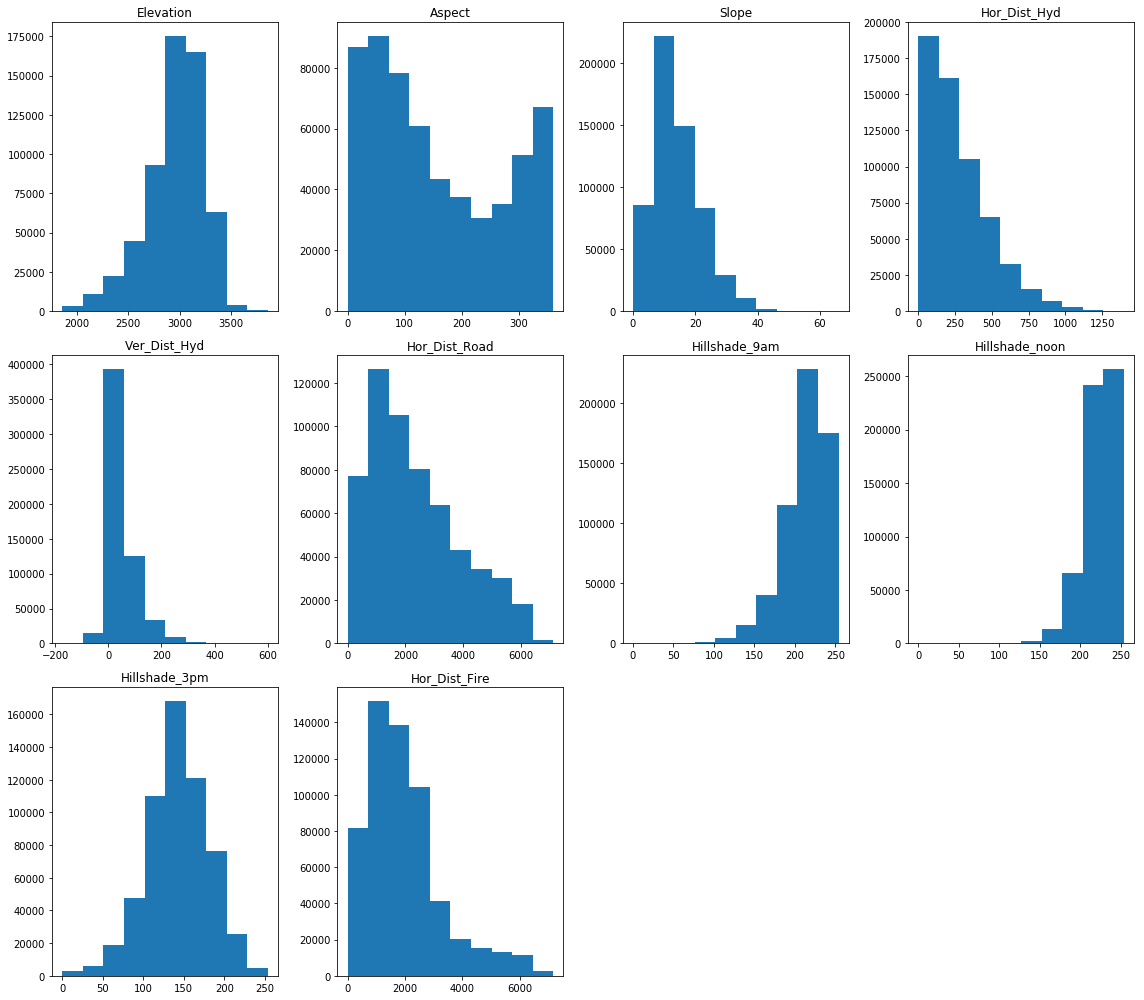

In [80]:
# Visualize distributions of continuous variables
to_hist = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
           'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
           'Hor_Dist_Fire']

plt.figure(figsize=(16,14))
for idx, col in enumerate(to_hist):
    plt.subplot(3, 4, idx+1)
    plt.hist(df[col])
    plt.title(col)
plt.tight_layout();


# Preprocessing

## Resampling and scaling

In [65]:
# Subset the cover types
cover_1 = df[df.Cover_Type == 1]
cover_2 = df[df.Cover_Type == 2]
cover_3 = df[df.Cover_Type == 3]
cover_4 = df[df.Cover_Type == 4]
cover_5 = df[df.Cover_Type == 5]
cover_6 = df[df.Cover_Type == 6]
cover_7 = df[df.Cover_Type == 7]

In [66]:
# Sample the cover type subsets
cover_1 = cover_1.sample(9493, random_state=1)
cover_2 = cover_2.sample(9493, random_state=1)
cover_3 = cover_3.sample(9493, random_state=1)
cover_6 = cover_6.sample(9493, random_state=1)
cover_7 = cover_7.sample(9493, random_state=1)

In [67]:
# Check that sampling was successful
len(cover_1)

9493

In [68]:
# Concatenate the subsets into one DataFrame
sample = pd.concat([cover_1, cover_2, cover_3, cover_4, cover_5, cover_6, 
                    cover_7], axis=0, ignore_index=True)
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59705 entries, 0 to 59704
Data columns (total 55 columns):
Elevation         59705 non-null int64
Aspect            59705 non-null int64
Slope             59705 non-null int64
Hor_Dist_Hyd      59705 non-null int64
Ver_Dist_Hyd      59705 non-null int64
Hor_Dist_Road     59705 non-null int64
Hillshade_9am     59705 non-null int64
Hillshade_noon    59705 non-null int64
Hillshade_3pm     59705 non-null int64
Hor_Dist_Fire     59705 non-null int64
WA_1              59705 non-null int64
WA_2              59705 non-null int64
WA_3              59705 non-null int64
WA_4              59705 non-null int64
Soil_Type_1       59705 non-null int64
Soil_Type_2       59705 non-null int64
Soil_Type_3       59705 non-null int64
Soil_Type_4       59705 non-null int64
Soil_Type_5       59705 non-null int64
Soil_Type_6       59705 non-null int64
Soil_Type_7       59705 non-null int64
Soil_Type_8       59705 non-null int64
Soil_Type_9       59705 non-null 

In [69]:
# Confirm that classes are balanced
sample.Cover_Type.value_counts()

7    9493
6    9493
5    9493
3    9493
2    9493
1    9493
4    2747
Name: Cover_Type, dtype: int64

In [70]:
# Use SMOTE to oversample the minority class
y_for_smote = sample['Cover_Type']
X_for_smote = sample.drop('Cover_Type', axis=1)

smote = SMOTE(random_state=1)
X, y = smote.fit_resample(X_for_smote, y_for_smote)

# Check count of each class
Counter(y)

Counter({1: 9493, 2: 9493, 3: 9493, 4: 9493, 5: 9493, 6: 9493, 7: 9493})

In [78]:
# Save the clean dataset for easier access later
sample = pd.concat([pd.DataFrame(X), pd.DataFrame(y, columns=['Cover_Type'])], axis=1)
sample.to_csv('trees.csv')

In [79]:
sample = pd.read_csv('trees.csv')
sample.drop('Unnamed: 0', axis=1, inplace=True)
sample.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,Cover_Type
0,3160,347,13,127,15,4621,196,219,162,3139,...,0,0,0,0,0,0,0,0,0,1
1,3100,352,9,170,14,5367,205,225,158,1167,...,0,0,0,0,0,0,0,0,0,1
2,2675,31,11,212,20,3360,217,216,133,3072,...,0,0,0,0,0,0,0,0,0,1
3,3088,43,8,0,0,1611,222,222,136,674,...,0,0,0,0,0,0,0,0,0,1
4,3061,113,22,150,19,696,251,212,78,742,...,0,0,0,0,0,0,0,0,0,1


In [81]:
# Scale the features
from sklearn.preprocessing import MinMaxScaler

y = sample['Cover_Type']
X = sample.drop('Cover_Type', axis=1)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [82]:
# Check the results
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,...,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000,66451.000000
mean,0.443993,0.435612,0.254144,0.167631,0.269497,0.245661,0.837816,0.861501,0.536535,0.213942,...,0.021128,0.043942,0.042106,0.001505,0.007449,0.000451,0.001911,0.049104,0.044484,0.028051
std,0.209862,0.305167,0.129847,0.153517,0.081094,0.190468,0.120205,0.090131,0.183566,0.155590,...,0.143813,0.204968,0.200833,0.038764,0.085987,0.021243,0.043676,0.216086,0.206169,0.165119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.256269,0.183333,0.153846,0.049410,0.208499,0.107291,0.771654,0.814961,0.422311,0.103623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.446339,0.347222,0.230769,0.132743,0.244356,0.188329,0.866142,0.874016,0.549801,0.178742,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.624624,0.722222,0.338462,0.243363,0.306773,0.327579,0.929134,0.925197,0.665339,0.280609,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


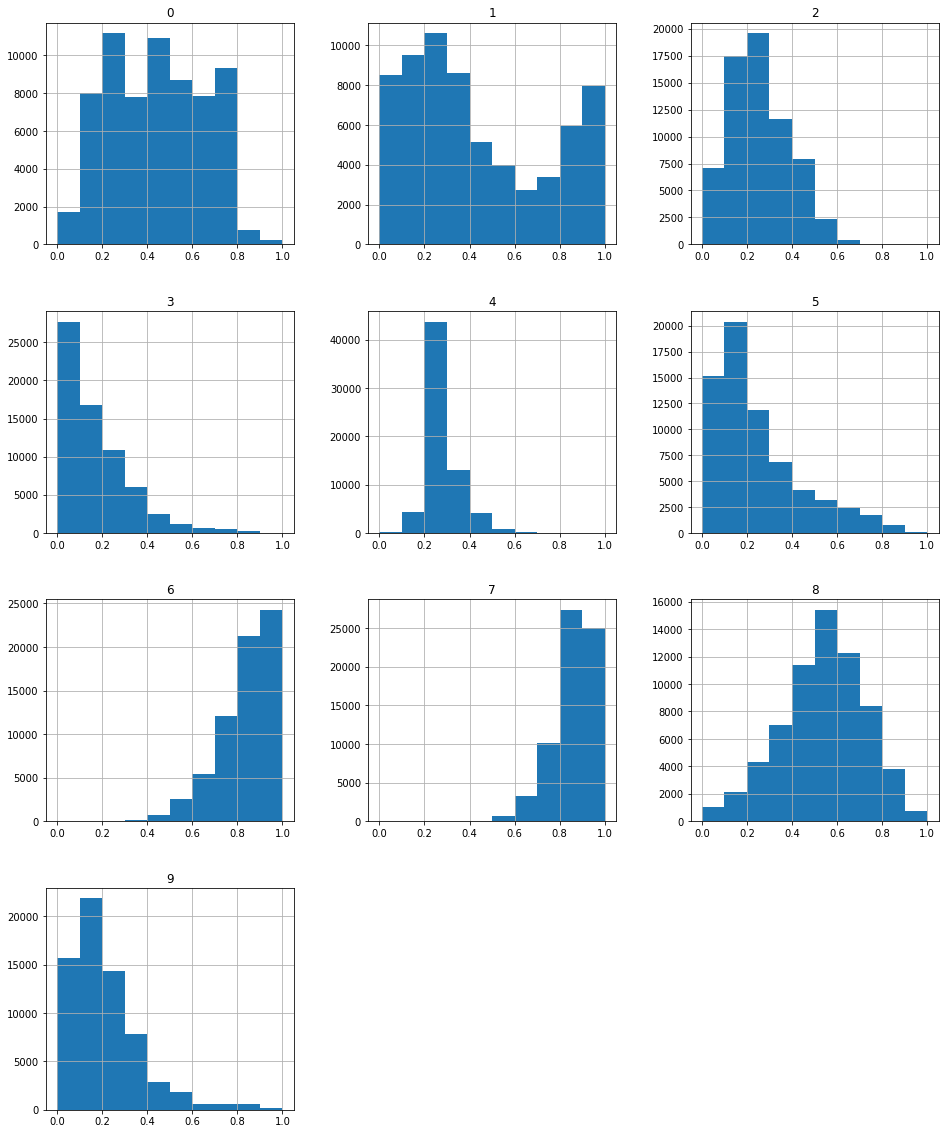

In [83]:
# Visualize the distributions again
X.loc[:,:9].hist(figsize=(16, 20));

## PCA

Principal Components Analysis takes the features we have and tries to combine them in ways that maximize the amount of variance the components can explain in the data. For datasets like the one I'm working with here, where there are lots of features, PCA can help us avoid the negative effects of having numerous features while still allowing us to account for as much variance as possible. For my analysis below, I aim to find a number of components that will explain at least 90% of the variance in the data.

First, let's see how much variance we can explain with a wide range of components. If any of these look promising, we can drill down further.

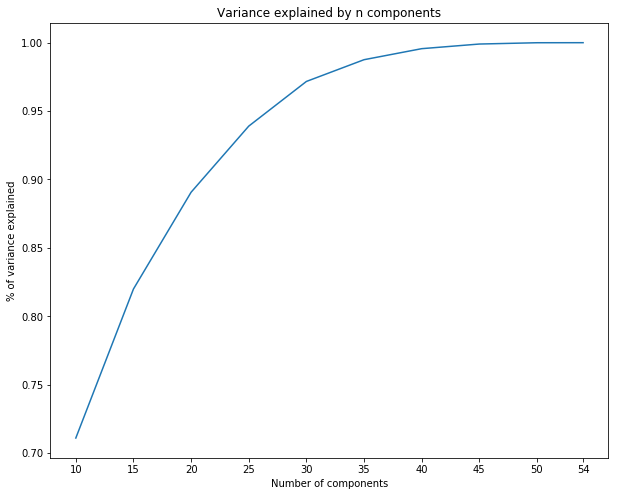

In [19]:
# Try several numbers of components to explain 90% of variance
comps = [10, 15, 20, 25, 30, 35, 40, 45, 50, 54]
var_sums = []
for comp in comps:
    pca = PCA(n_components=comp)
    pca.fit_transform(X)
    var_sums.append(np.sum(pca.explained_variance_ratio_))
    
# Visualize results
plt.figure(figsize=(10,8))
plt.plot(comps, var_sums)
plt.xlabel('Number of components')
plt.ylabel('% of variance explained')
plt.title('Variance explained by n components')
plt.xticks([10, 15, 20, 25, 30, 35, 40, 45, 50, 54])
plt.show();

In [20]:
# View the % variance explained for each number of components
display(list(zip(comps, var_sums)))

[(10, 0.7109654754047361),
 (15, 0.819922021770772),
 (20, 0.8906735474037801),
 (25, 0.938999635323969),
 (30, 0.9716586771389896),
 (35, 0.9875599309827012),
 (40, 0.9956233050414862),
 (45, 0.999013113610837),
 (50, 0.9999615256208412),
 (54, 0.9999999999999998)]

From the plot and the list above, it's clear that we could explain 99.6% of the variance in the data with 40 components (out of a possible 54); there is very little to gain by including any more components than that. Using fewer features/components will help us avoid overfitting on the training data, but at the expense of a little bit of accuracy. I think it's a worthwhile trade, so from here onward I will use a transformed version of the dataset with 40 components for developing my models.

In [21]:
# Transform the dataset to have 40 principal components
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X)
np.sum(pca.explained_variance_ratio_)

0.9956233050414861

This transformation will form part of the final pipeline.

## Train-validation-test split

In [22]:
# Create training, validation, and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2,
                                                    random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=1)

In [ ]:
# Examine shapes of the subsets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# Testing various algorithms

## Random Forest

### Baseline model

In [26]:
# Fit and score a baseline RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

y_pred = forest.predict(X_train)

print_metrics(y_train, y_pred)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training accuracy: 0.9959838476056709
-------
Confusion matrix:
[[7481   14    0    1    0   16]
 [  62 7488    1   11    7    2]
 [   0    3 7598    2   12    0]
 [   0    5    4 7588    1    0]
 [   0    0   33    1 7589    0]
 [   7    1    0    0    0 7639]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99      7512
           2       1.00      0.99      0.99      7571
           3       1.00      1.00      1.00      7615
           5       1.00      1.00      1.00      7598
           6       1.00      1.00      1.00      7623
           7       1.00      1.00      1.00      7647

   micro avg       1.00      1.00      1.00     45566
   macro avg       1.00      1.00      1.00     45566
weighted avg       1.00      1.00      1.00     45566



In [35]:
forest.score(X_val, y_val)

0.8799157303370787

The Random Forest scored over 99% accuracy on the training set, but only 88% on the validation set. While this is still an excellent score, the 11% gap between the training and validation scores makes we worry that the forest may have overfit to the training data. Below I'll use a grid search to see if there are other parameters that would help the Random Forest perform better on the validation set.

For now, let's take a look at the importance the Random Forest assigned to each of the 40 components.

In [27]:
# Check the feature importances
forest.feature_importances_

array([0.03636125, 0.09361649, 0.01782079, 0.03471416, 0.06652192,
       0.05621573, 0.02646655, 0.04067616, 0.03076527, 0.04217807,
       0.01981662, 0.03590902, 0.01710245, 0.02226153, 0.02227806,
       0.0126515 , 0.01776493, 0.01773845, 0.02002115, 0.02107243,
       0.02382588, 0.01171429, 0.01355813, 0.01206029, 0.02588517,
       0.01417241, 0.01458683, 0.01228844, 0.01277972, 0.01125138,
       0.01413946, 0.02668384, 0.02215608, 0.02706921, 0.02943163,
       0.01109597, 0.02064267, 0.01771598, 0.01510406, 0.01188604])

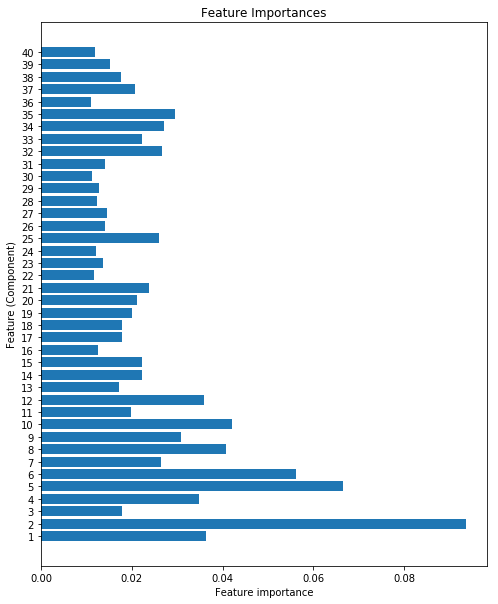

In [30]:
# Visualize feature importances
plot_feature_importances(forest)

The plot above shows that there are a few features that are a bit more powerful than the rest. A grid search (below) will help me determine if any of the less important features could be eliminated.

### Tune parameters with GridSearchCV

In [34]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [50, 100, 150],
          'max_depth': [5, 10],
          'max_features': [20, 30, 40]}

grid_forest = GridSearchCV(forest, params, cv=3, scoring='accuracy')
grid_forest.fit(X_train, y_train)
y_pred = grid_forest.predict(X_train)

print('Best score:', grid_forest.best_score_)
print('Best params:', grid_forest.best_params_)

KeyboardInterrupt: 

In [21]:
# View the metrics for the best model
print_metrics(y_train, y_pred)

Training accuracy: 0.8407696989559437
-------
Confusion matrix:
[[5454  868    3  257   34  393]
 [1203 4380  127 1083  269   42]
 [   0    8 5998  213  952    0]
 [   4  108  132 6784  107    0]
 [   0    0  374  294 6472    0]
 [ 310    4    0   17    0 6828]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.78      0.78      0.78      7009
           2       0.82      0.62      0.70      7104
           3       0.90      0.84      0.87      7171
           5       0.78      0.95      0.86      7135
           6       0.83      0.91      0.86      7140
           7       0.94      0.95      0.95      7159

   micro avg       0.84      0.84      0.84     42718
   macro avg       0.84      0.84      0.84     42718
weighted avg       0.84      0.84      0.84     42718



In [27]:
# Check the model's score for the validation dataset
grid_forest.score(X_val, y_val)

0.811622191011236

### Evaluating the best Random Forest classifier

In [37]:
# Review feature importances for the model with the best parameters
forest_best = RandomForestClassifier(max_depth=10, max_features=40, 
                                 n_estimators=150)
forest_best.fit(X_train, y_train)

plot_feature_importances(forest_best)

KeyboardInterrupt: 

In [41]:
# View metrics for the optimized model
y_pred = forest_best.predict(X_train)
print_metrics(y_train, y_pred)

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

In [42]:
# Score the model on the validation set
forest_best.score(X_val_trans, y_val)

ValueError: operands could not be broadcast together with shapes (5696,40) (54,) 

In [55]:
# View full metrics for the validation set
y_val_pred = forest_best.predict(X_val_trans)
print_metrics(y_val, y_val_pred)

Training accuracy: 0.8012640449438202
-------
Confusion matrix:
[[734 157   0  25   2  56]
 [203 570  24 113  32   4]
 [  0   4 745  31 170   0]
 [  5  46  16 850  16   0]
 [  1   7 145  26 788   0]
 [ 47   0   0   2   0 877]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.74      0.75      0.75       974
           2       0.73      0.60      0.66       946
           3       0.80      0.78      0.79       950
           5       0.81      0.91      0.86       933
           6       0.78      0.81      0.80       967
           7       0.94      0.95      0.94       926

   micro avg       0.80      0.80      0.80      5696
   macro avg       0.80      0.80      0.80      5696
weighted avg       0.80      0.80      0.80      5696



In [ ]:
# Find AUC and plot ROC curve
# y_score_forest = forest_best.fit(X_train, y_train).decision_function(X_test)

roc_it(y_test, y_score_forest)

## XGBoost

### Baseline model

In [22]:
import xgboost as xgb

In [23]:
xg = xgb.XGBClassifier()

In [ ]:
xg.fit(X_train, y_train)

In [ ]:
y_pred = xg.predict(X_train)

print_metrics(y_train, y_pred)

In [ ]:
xg.score(X_val, y_val)

### Tune parameters with GridSearchCV

In [ ]:
params = {'learning_rate': [0.01, 0.1],
          'max_depth': [5, 10, 15],
          'n_estimators': [5, 30, 100, 250]
}

grid_xgb = GridSearchCV(xgboost, params, scoring='accuracy', cv=3, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print('Best score:', grid_xgb.best_score_)
print('Best params:', grid_xgb.best_params_)

In [ ]:
y_pred = grid_xgb.predict(X_train)

print_metrics(y_train, y_pred)

In [ ]:
grid_xgb.score(X_val, y_val)

### Evaluating the best XGBoost classifier

In [ ]:
# Build the optimized model
# xgb_best = XGBClassifier() # insert best params
# xgb_best.fit(X_train, y_train)

In [ ]:
# View metrics for the optimized model
# y_pred = xgb_best.predict(X_train)
# print_metrics(y_train, y_pred)

In [ ]:
# Score the model on the validation set
# xgb_best.score(X_val_trans, y_val)

In [ ]:
# View full metrics for the validation set
# y_val_pred = xgb_best.predict(X_val_trans)
# print_metrics(y_val, y_val_pred)

In [ ]:
# Find AUC and plot ROC curve
# y_score_xg = xgb_best.fit(X_train, y_train).decision_function(X_test)

# roc_it(y_test, y_score_xg)

## Support Vector Machine

### Baseline model

In [45]:
# Build a baseline model
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [46]:
y_pred = svc.predict(X_train)
print_metrics(y_train, y_pred)

Training accuracy: 0.6421674055216609
-------
Confusion matrix:
[[4630 1731    9  281   61  800]
 [1710 4102  189 1206  323   41]
 [   0   28 4567  307 2713    0]
 [ 169 1486  691 5008  244    0]
 [   0  341 1985  472 4825    0]
 [1491    0   27    0    0 6129]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.58      0.62      0.60      7512
           2       0.53      0.54      0.54      7571
           3       0.61      0.60      0.61      7615
           5       0.69      0.66      0.67      7598
           6       0.59      0.63      0.61      7623
           7       0.88      0.80      0.84      7647

   micro avg       0.64      0.64      0.64     45566
   macro avg       0.65      0.64      0.64     45566
weighted avg       0.65      0.64      0.64     45566



In [47]:
svc.score(X_val, y_val)

0.6346558988764045

### Tune parameters with GridSearchCV

In [48]:
params = {'gamma': [0.1, 1.0, 100.0],
          'C': [0.1, 1.0, 10.0]}

grid_svc = GridSearchCV(svc, params, cv=3, scoring='accuracy')
grid_svc.fit(X_train, y_train)


print('Best score:', grid_svc.best_score_)
print('Best params:', grid_svc.best_params_)

KeyboardInterrupt: 

In [ ]:
y_pred = grid_svc.predict(X_train)
print_metrics(y_train, y_pred)

In [ ]:
grid_svc.score(X_val, y_val)

### Evaluating the best Support Vector classifier

In [ ]:
# Build the optimized model
# svc_best = SVC() # insert best params
# svc_best.fit(X_train, y_train)

In [ ]:
# View metrics for the optimized model
# y_pred = svc_best.predict(X_train)
# print_metrics(y_train, y_pred)

In [ ]:
# Score the model on the validation set
# svc_best.score(X_val_trans, y_val)

In [ ]:
# View full metrics for the validation set
# y_val_pred = svc_best.predict(X_val_trans)
# print_metrics(y_val, y_val_pred)

In [ ]:
# Find AUC and plot ROC curve
# y_score_xg = svc_best.fit(X_train, y_train).decision_function(X_test)

# roc_it(y_test, y_score_xg)

# With SMOTE

In [53]:
# Use SMOTE to oversample the minority class
from imblearn.over_sampling import SMOTE

cover_4 = df[df.Cover_Type == 4]
sample_up = pd.concat([sample, cover_4], axis=0, ignore_index=True)

y_up = sample_up['Cover_Type']
X_up = sample_up.drop('Cover_Type', axis=1)

smote = SMOTE(random_state=1)
X_res, y_res = smote.fit_resample(X_up, y_up)


In [54]:
from collections import Counter
Counter(y_res)

Counter({1: 9493, 2: 9493, 3: 9493, 5: 9493, 6: 9493, 7: 9493, 4: 9493})

In [56]:
X_res_trans = pca.transform(X_res)

X_train, X_test, y_train, y_test = train_test_split(X_res_trans, y_res, 
                                                    test_size=0.2,
                                                    random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                test_size=0.5,
                                                random_state=2)

forest_best = RandomForestClassifier(max_depth=10, max_features=40, 
                                 n_estimators=150)
forest_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
y_pred = forest_best.predict(X_train)

print_metrics(y_train, y_pred)

Training accuracy: 0.8557562076749435
-------
Confusion matrix:
[[5435  831    9    0  293   15  981]
 [1168 4946  266    3  942  229  106]
 [   0   54 6114  376  116  868    0]
 [   0    0  119 7435    0   75    0]
 [   0   47  112    0 7365   67    0]
 [   0   29  416  262  138 6732    0]
 [ 133    9    0    0    4    0 7465]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.81      0.72      0.76      7564
           2       0.84      0.65      0.73      7660
           3       0.87      0.81      0.84      7528
           4       0.92      0.97      0.95      7629
           5       0.83      0.97      0.90      7591
           6       0.84      0.89      0.87      7577
           7       0.87      0.98      0.92      7611

   micro avg       0.86      0.86      0.86     53160
   macro avg       0.85      0.86      0.85     53160
weighted avg       0.85      0.86      0.85     53160



In [58]:
forest_best.score(X_val, y_val)

0.8209179834462002

# Interpretations and recommendations